# Data driven approach

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Import data
experiments = pd.read_csv("/workspaces/MA932-Project/n73_stabilization.csv")
# NOTE: Fixed radius 16.75
experiments = experiments[['TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']] # Columns of interest

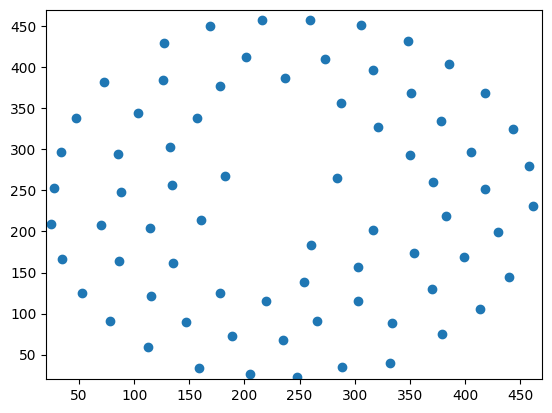

In [49]:
# Create trajectories animation

frames_num = len(pd.unique(experiments['FRAME']))

# Create a figure and axis
fig, ax = plt.subplots()

# Create an empty scatter plot (initially no balls are shown)
scatter = ax.scatter([], [])
ax.set(xlim=[20, 470], ylim=[20, 470])

# Function to update the scatter plot with new ball positions
def update(frame):
    frame_df = experiments[experiments['FRAME'] == frame]
    x = frame_df['POSITION_X']
    y = frame_df['POSITION_Y']

    # update the scatter plot:
    data = np.stack([x, y]).T
    scatter.set_offsets(data)

    return scatter,

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=range(frames_num), interval=50, blit=True)
ani.save('animation.gif', writer='pillow')